# Astrometry + RV analysis

## Authors

Nicolas Unger (DACE Data Scientist)

Jean-Baptiste Delisle (DACE Data Scientist)

## Requirements

Anaconda 3, Python 3.8 or later, IPython 7.8.0<br>

**`dace-query`** : 1.2.0 or later

**`kepmodel`** : 1.0.7 or later

**`spleaf`** : 2.1.12 or later

## Introduction

In this tutorial, we will demonstrate how to fit astrometric and radial velocity (RV) orbits using Hipparcos data. We will use the `dace-query` and `kepmodel` packages to access and analyze the data. The target star for this tutorial is HD 17289, replicating the analysis that was done in [Delisle et al. 2022](https://ui.adsabs.harvard.edu/abs/2022A%26A...667A.172D/abstract). By the end of this tutorial, you will learn how to:

1. Retrieve relevant data using the DACE API.
2. Perform a joint analysis of astrometry and RV data.
3. Identify potential companions using periodograms.
4. Visualize the fitted orbits and residuals.

Let's get started!

## 0. Imports and Setup

First, we need to import the necessary libraries and set up some constants and parameters. This includes defining astronomical constants, target star information, and observational parameters. We will also configure the instruments and analysis settings.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from dace_query.astrometry import Astrometry
from dace_query.spectroscopy import Spectroscopy
from kepmodel import astro, astrorv, rv
from spleaf import term

2025-10-14 15:23:27,319 - WARNING - File .dacerc not found. You are requesting data in public mode. To change this behaviour, create a .dacerc file in your home directory and fill it with your API key. More infos on https://dace.unige.ch


In [2]:
# Define target star and observational parameters
target = "HD 17289"  # Target star name
ms = 1.01  # Stellar mass in solar masses
epoch_rjd = 50_000  # Reduced Julian Date epoch
epoch_bjd = 2_400_000 + epoch_rjd  # Barycentric Julian Date epoch

# Defaults
default_hip_jitter = 0.0  # Default HIPPARCOS jitter value
# Default instrument jitter value
default_inst_jitter = {
    "CORALIE98": 5.0,
    "CORALIE07": 8.0,
}
# Default instrument colors for plotting
default_inst_color = {
    "CORALIE98": "deepskyblue",
    "CORALIE07": "darkviolet",
}

## 1. Getting the Data


### CORALIE RV Data

We will start by retrieving the radial velocity (RV) data for our target star, HD 17289, using the `dace-query` package. We will filter the data to include only observations from the CORALIE98 and CORALIE07 instruments.

In [3]:
rv_data = (
    Spectroscopy.query_database(
        filters={
            # Filter by object name for HD17289
            "obj_id_catname": {"contains": ["HD17289"]},
            # Filter by instrument name to use only the data from CORALIE98 and CORALIE07
            "ins_name": {"contains": ["CORALIE98", "CORALIE07"]},
            # Filter only the data with well behaved uncertainties
            "spectro_ccf_rv_err": {"max": 50},
        },
        output_format="pandas",
    )
    # Sort the data by date
    .sort_values("obj_date_bjd")
    # Reset the index
    .reset_index(drop=True)
)

# Get the list of instruments
instruments = rv_data["ins_name"].unique()

In [4]:
rv_data.head()

,obj_id_catname,obj_pos_coordinates_hms_dms,ins_name,prog_id,obj_date_bjd,date_night,ins_drs_version,pub_bibcode,pub_ref,ins_mode,...,ins1_adc2_temp,ins2_adc1_temp,ins2_adc2_temp,ins3_adc1_temp,ins3_adc2_temp,ins4_adc1_temp,ins4_adc2_temp,th_ar,th_ar1,th_ar2
0,HD17289,02:43:35.5 / -62:55:08.8,CORALIE98,703,51128.699883,1998-11-10,3.3,,,CORALIE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,HD17289,02:43:35.5 / -62:55:08.8,CORALIE98,703,51410.916661,1999-08-19,3.3,,,CORALIE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,HD17289,02:43:35.5 / -62:55:08.8,CORALIE98,703,51814.792299,2000-09-26,3.3,,,CORALIE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,HD17289,02:43:35.5 / -62:55:08.8,CORALIE98,703,51814.804000,2000-09-26,3.3,,,CORALIE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HD17289,02:43:35.5 / -62:55:08.8,CORALIE98,703,51901.658240,2000-12-22,3.3,,,CORALIE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Hipparcos Astrometry Data

Next, we will retrieve the astrometric data from the Hipparcos mission. We will bin the astrometric measurements by 1-day intervals to reduce noise and compute weighted averages within each bin.

In [5]:
astrometry_data = Astrometry.get_hipparcos_timeseries(
    "HD 17289", output_format="pandas"
)

In [6]:
astrometry_data

,IORB,EPOCH,PARF,CPSI,SPSI,RES,SRES,HIP,T_BJD,S_MAS,CTH,STH,IAD_SOURCE
0,77,-1.3126,-0.6708,-0.2584,0.9660,1.95,7.14,12726,2447869.8,25.078316,0.9660,-0.2584,JavaTool
1,77,-1.3126,-0.6705,-0.2588,0.9659,-5.98,7.27,12726,2447869.8,17.136045,0.9659,-0.2588,JavaTool
2,77,-1.3126,-0.6715,-0.2574,0.9663,-2.07,7.02,12726,2447869.8,21.092407,0.9663,-0.2574,JavaTool
3,77,-1.3126,-0.6712,-0.2578,0.9662,-2.61,7.12,12726,2447869.8,20.540138,0.9662,-0.2578,JavaTool
4,129,-1.2493,0.6570,-0.9788,0.2048,-7.48,6.94,12726,2447892.8,-16.565117,0.2048,-0.9788,JavaTool
...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,2521,1.6568,-0.6726,-0.4346,0.9006,-12.12,8.68,12726,2448954.2,-61.341230,0.9006,-0.4346,JavaTool
109,2667,1.8340,0.6098,-0.7155,0.6986,-13.77,7.29,12726,2449019.0,-13.163609,0.6986,-0.7155,JavaTool
110,2667,1.8340,0.6101,-0.7159,0.6982,-15.56,7.53,12726,2449019.0,-14.901564,0.6982,-0.7159,JavaTool
111,2747,1.9311,-0.5815,0.9449,0.3273,11.27,7.26,12726,2449054.5,-71.525770,0.3273,0.9449,JavaTool


The first columns are the original ones from the 2007 reduction by van Leeuwen. Here is an explanation for each parameter:

- IORB (-): Orbit number.
- EPOCH (years): Observation epoch, given as Year - 1991.25.
- PARF (-): Parallax factor.
- CPSI (-): Cosine of Psi.
- SPSI (-): Sine of Psi.
- RES (mas): Abscissa residual.
- SRES (mas): Formal error on abscissa residual.

Then the new columns identify the target, add the timeseries of the absolute astrometry (the original residuals with the 5, 7, or 9 parameter model added back in), the scan angle in the Gaia convention and the source of the original Intermediate Astrometric Data.

- HIP (-): Hipparcos identifier.
- T_BJD (days): Epoch in Barycentric Julian Date (BJD).
- S_MAS (mas): Absolute astrometric signal, RES + fitted model.
- CTH (-): Cosine of the theta angle, following Gaia convention.
- STH (-): Sine of the theta angle, following Gaia convention.
- IAD_SOURCE (-): Indicates the source of the IAD, either "Brandt2021" or "JavaTool".

Here is a digram explaining the different scan angle conventions between Hipparcos and Gaia:

![image](scan_angle_convention.png)

In [7]:
# Bin astrometric measurements by 1-day intervals to reduce noise
astrometry_data["bin"] = (astrometry_data["T_BJD"] // 1).astype(int)

# Compute weighted averages within each bin
w = 1 / astrometry_data["SRES"] ** 2
astro_data = (
    astrometry_data.groupby("bin")
    .apply(
        lambda x: pd.Series(
            {
                col: np.average(x[col], weights=w.loc[x.index])
                for col in x.columns
                if (col != "SRES") and (col != "IAD_SOURCE")
            }
            | {"SRES": np.sqrt(1 / np.sum(w.loc[x.index]))}
        )
    )
    .reset_index(drop=True)
)

## 2. Initialize the Models

In this step, we will initialize the models for the astrometry, RV, and joint astrometry+RV analyses. We will start by fitting only the linear parameters of each model before adding any Keplerian parameters.

### Astrometry

We will initialize the astrometric model and fit the linear parameters, including parallax, position, and proper motion.

In [8]:
# Initialize astrometric model
astro_model = astro.AstroModel(
    astro_data["T_BJD"].values - epoch_bjd,
    astro_data["S_MAS"].values,
    astro_data["CTH"].values,
    astro_data["STH"].values,
    angular_keplerian_param=False,
    err=term.Error(astro_data["SRES"].values),
    jit=term.Jitter(default_hip_jitter),  # Set default jitter
)

# Fit linear parameters to astrometric data
dt_yr = (astro_data["T_BJD"] - epoch_bjd) / 365.25  # Convert time to years
# Add basic astrometric parameters (parallax, position, proper motion)
astro_model.add_lin(astro_data["PARF"], "plx")
astro_model.add_lin(astro_data["CTH"], "delta")
astro_model.add_lin(astro_data["STH"], "alpha")
astro_model.add_lin(dt_yr * astro_data["CTH"], "mud")
astro_model.add_lin(dt_yr * astro_data["STH"], "mua")

# Fit the astrometric model to the data and show the parameters
astro_model.fit()
astro_model.show_param()

# Print the loglikelihood of the model
print(f"loglikelihood = {astro_model.loglike():.3f}")

Parameter                        Value     Error       
lin.plx                          20.80  ±  1.12        
lin.delta                      -163.85  ±  5.53        
lin.alpha                      -118.37  ±  4.99        
lin.mud                         -36.25  ±  1.22        
lin.mua                         -26.19  ±  1.11        

loglikelihood = -136.744


### RV

Next, we will initialize the RV model and fit the linear parameters, such as the offsets for each instrument.

In [9]:
# Define the RV jitter
instjit = {
    "jit_CORALIE98": term.InstrumentJitter(
        rv_data["ins_name"].values == "CORALIE98", default_inst_jitter["CORALIE98"]
    ),
    "jit_CORALIE07": term.InstrumentJitter(
        rv_data["ins_name"].values == "CORALIE07", default_inst_jitter["CORALIE07"]
    ),
}

# Initialize the RV model
rv_model = rv.RvModel(
    rv_data["obj_date_bjd"].values - epoch_rjd,
    rv_data["spectro_ccf_rv"].values,
    err=term.Error(rv_data["spectro_ccf_rv_err"].values),
    **instjit,
)

# Fit linear parameters to RV data
for inst in instruments:
    rv_model.add_lin(1.0 * (rv_data["ins_name"] == inst), f"offset_inst_{inst}")

print("Fit linear parameters:")
rv_model.fit()
rv_model.show_param()

print(f"loglikelihood = {rv_model.loglike():.3f}")

Fit linear parameters:
Parameter                        Value     Error       
lin.offset_inst_CORALIE98     35208.71  ±  1.91        
lin.offset_inst_CORALIE07     35217.20  ±  2.50        

loglikelihood = -154992.595


### Joint RV+Astrometry

Finally, we will combine the astrometric and RV models into a joint model and fit the linear parameters. This joint model will allow us to perform a comprehensive analysis of the data.

In [10]:
# Combine astrometric and RV models
full_model = astrorv.AstroRvModel(astro_model, rv_model)
# Fit all parameters
full_model.fit()
# Show the parameters of the full model
full_model.show_param()

print(f"loglikelihood = {full_model.loglike():.3f}")

Parameter                        Value     Error       
astro.lin.plx                    20.80  ±  1.12        
astro.lin.delta                -163.85  ±  5.53        
astro.lin.alpha                -118.37  ±  4.99        
astro.lin.mud                   -36.25  ±  1.22        
astro.lin.mua                   -26.19  ±  1.11        
rv.lin.offset_inst_CORALIE98     35208.71  ±  1.91        
rv.lin.offset_inst_CORALIE07     35217.20  ±  2.50        

loglikelihood = -155129.339


### Plot residuals of current model fits

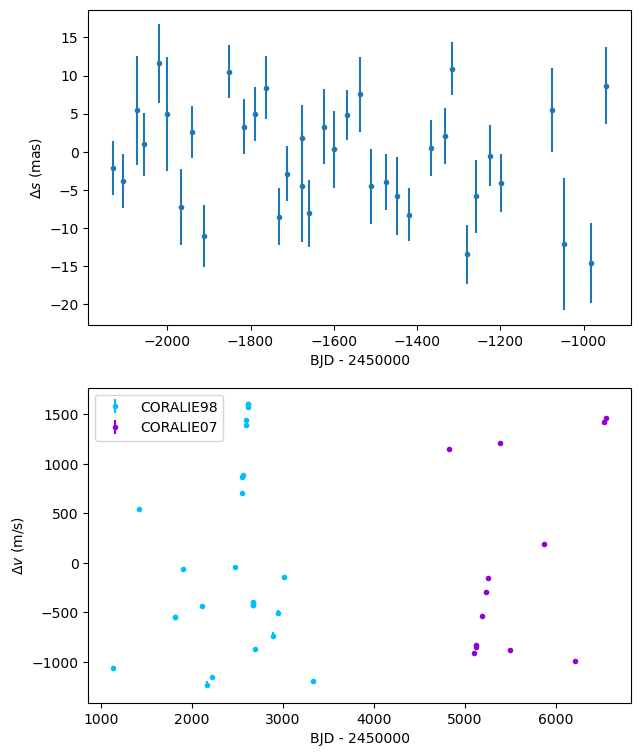

In [11]:
# Create subplot for both astrometry and RV residuals
_, axs = plt.subplots(2, 1, figsize=(7, 9))

# Plot astrometric residuals
ax = axs[0]
astro_res = astro_model.residuals()
astro_res_err = np.sqrt(astro_model.cov.A)
ax.errorbar(astro_model.t, astro_res, yerr=astro_res_err, fmt=".", rasterized=True)
ax.set_xlabel(f"BJD - {epoch_bjd}")
ax.set_ylabel("$\\Delta s$ (mas)")

# Plot RV residuals by instrument
ax = axs[1]
rv_res = rv_model.residuals()
rv_res_err = np.sqrt(rv_model.cov.A)
for inst in instruments:
    kinst = rv_data.ins_name == inst
    ax.errorbar(
        rv_model.t[kinst],
        rv_res[kinst],
        yerr=rv_res_err[kinst],
        fmt=".",
        c=default_inst_color.get(inst, None),
        rasterized=True,
        label=inst,
    )
ax.set_xlabel(f"BJD - {epoch_bjd}")
ax.set_ylabel("$\\Delta v$ (m/s)")
ax.legend()

## 3. Find Planets

We will use periodograms to identify potential planetary companions in the data. By analyzing the periodograms of the residuals from the astrometry, RV, and joint models, we can estimate the periods of any detected signals.

In [12]:
# Define periodogram parameters for frequency analysis
Pmin = 0.9  # Minimum period in days
Pmax = 50000  # Maximum period in days
nfreq = 50000  # Number of frequency steps
nu0 = 2 * np.pi / Pmax  # Initial frequency
dnu = (2 * np.pi / Pmin - nu0) / (nfreq - 1)  # Frequency step size

Text(0.5, 0, 'Period (d)')

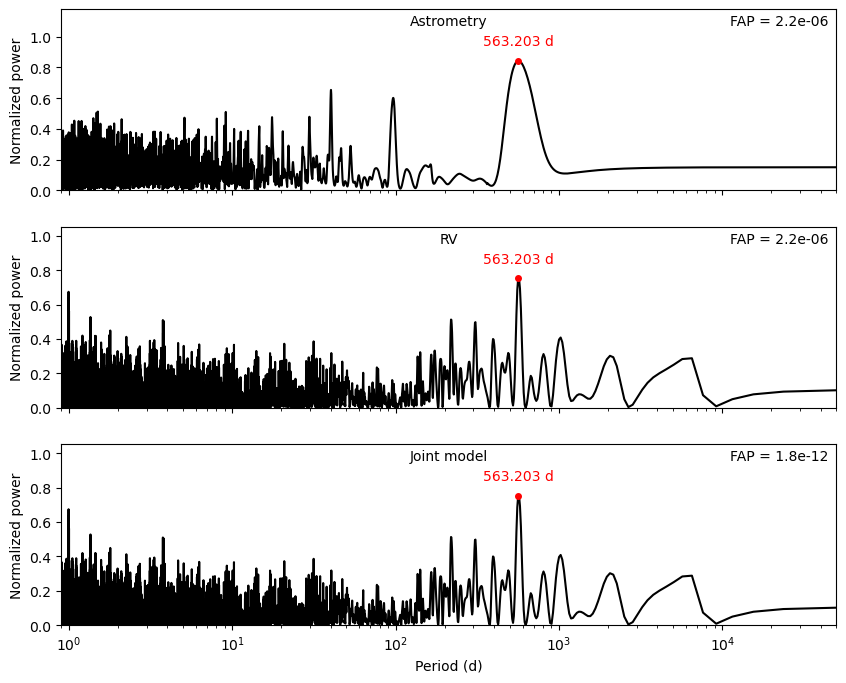

In [13]:
# Compute and plot periodograms for signal detection

# Setup subplots for periodogram analysis
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 8))
models = [astro_model, rv_model, full_model]
model_titles = ["Astrometry", "RV", "Joint model"]

# Analyze each model's periodogram
for idx, model in enumerate(models):
    ax = axs[idx]

    # Calculate periodogram
    nu, power = model.periodogram(nu0, dnu, nfreq)
    P = 2 * np.pi / nu  # Convert frequency to period

    # Compute False Alarm Probability (FAP)
    max_power_idx = np.argmax(power)
    fap_level = model.fap(power[max_power_idx], nu.max())

    # Plot periodogram
    ax.plot(P, power, "k", lw=1.5, rasterized=True)
    ax.plot(P[max_power_idx], power[max_power_idx], "or", ms=4)
    ax.set_xscale("log")
    ax.set_xlim(Pmin, Pmax)
    ax.set_ylim(0, 1.4 * power.max())
    ax.set_ylabel("Normalized power")

    # Annotate the detected peak period
    ax.text(
        P[max_power_idx],
        power[max_power_idx] * 1.15,
        f"{P[max_power_idx]:.3f} d",
        horizontalalignment="right"
        if P[max_power_idx] > Pmax / 10
        else "left"
        if P[max_power_idx] < Pmin * 10
        else "center",
        verticalalignment="center",
        color="r",
    )

    # Display FAP level
    ax.text(
        0.99,
        0.97,
        f"FAP = {fap_level:.2g}",
        transform=ax.transAxes,
        horizontalalignment="right",
        verticalalignment="top",
    )

    # Display model type
    ax.text(
        0.5,
        0.97,
        model_titles[idx],
        transform=ax.transAxes,
        horizontalalignment="center",
        verticalalignment="top",
    )

ax.set_xlabel("Period (d)")

A clear signal is present at 563 days, and we can see that the FAP is many orders of magnitude lower in the Joint Model than any of the previous two models with only astrometry or only RV.

### Now we will add a keplerian to the model and fit again

In [14]:
### Adding a planet using combined astrometry and RV data ###

# Add keplerian from periodogram period and fit orbital parameters
full_model.add_keplerian_from_period(P[max_power_idx])
full_model.set_keplerian_param(
    f"{full_model.nkep - 1}", param=["P", "Marg0", "as", "e", "w", "i", "bigw"]
)
full_model.fit()

# Add jitters as a free parameter
astro_model.fit_param += ["cov.jit.sig"]
rv_model.fit_param += [f"cov.jit_{inst}.sig" for inst in instruments]

# Fit and show combined parameters
full_model.fit()
full_model.show_param()

print("Log-likelihood (Full):", full_model.loglike())

Parameter                        Value     Error       
astro.lin.plx                    20.68  ±  1.12        
astro.lin.delta                -167.86  ±  5.55        
astro.lin.alpha                -119.54  ±  5.07        
astro.lin.mud                   -38.45  ±  1.25        
astro.lin.mua                   -24.96  ±  1.12        
astro.cov.jit.sig                0.000  ±  0.749       
rv.lin.offset_inst_CORALIE98     34962.30  ±  5.13        
rv.lin.offset_inst_CORALIE07     34949.80  ±  2.95        
kep.0.P                       561.7065  ±  0.0726      
kep.0.Marg0 [deg]              161.742  ±  0.436       
kep.0.as                        0.5228  ±  0.0614      
kep.0.e                        0.52764  ±  0.00247     
kep.0.w [deg]                   51.801  ±  0.444       
kep.0.i [deg]                  173.277  ±  0.793       
kep.0.bigw [deg]                  0.95  ±  5.76        
rv.cov.jit_CORALIE98.sig         21.75  ±  3.72        
rv.cov.jit_CORALIE07.sig          8.99  ± 

### Compute Planetary Mass

Using the parameters obtained from the joint model, we will compute the mass of the detected planetary companion. This involves calculating the mean motion, semi-major axis, and iteratively solving for the planetary mass.

In [15]:
# Define astronomical constants
GmSun_AU3d2 = 0.0002959212  # Gravitational constant times mass of the Sun in AU^3/day^2
mJS = 0.000954791898312  # Mass of Jupiter in solar masses

In [18]:
# Get orbital period from full model
P = full_model.get_param("kep.0.P")

# Calculate mean motion (n = 2π/P)
n = 2 * np.pi / P

# Get semi-major axis in AU from model
a = full_model.get_param("kep.0.as")

# Calculate mass factor using Kepler's third law
# (n^2 * a^3) / G = (M* + Mp)^2
mass_factor = n**2 * a**3 / GmSun_AU3d2

# Iteratively solve for planetary mass
# Starting with mp = 0, iterate until convergence
mp = 0
for _ in range(10):
    mp = (mass_factor * (ms + mp) ** 2) ** (1 / 3)

# Print result in Jupiter masses
print(f"Companion mass: \n\t{mp / mJS:.2f} M_Jup\n\t{mp:.4f} M_Sun")

Companion mass: 
	546.01 M_Jup
	0.5213 M_Sun


With a mass of ~540 $M_{Jup}$, the companion is classified as a star, specifically an M dwarf. This classification is due to the high inclination of 173 degrees, which significantly affects the observed mass. The high inclination indicates that we are viewing the system nearly face-on, leading to a larger inferred mass for the companion than the one we get from RV alone.

## 4. Plot Orbits

We will visualize the fitted orbits and residuals for both the astrometry and RV data. This includes plotting the astrometric orbit, RV time series, and phase-folded RV curve.

In [19]:
# Extract residuals and errors for plotting
astro_res = astro_model.residuals()  # Get astrometric residuals
astro_err = np.sqrt(astro_model.cov.A)  # Get astrometric measurement errors
plx = astro_model.get_param("lin.plx")  # Get parallax value

rv_res = rv_model.residuals()  # Get RV residuals
rv_err = np.sqrt(rv_model.cov.A)  # Get RV measurement errors

# Define time range for plotting
Tmin = rv_model.t[0]
Tmax = rv_model.t[-1]
dT = Tmax - Tmin

# Get Keplerian model parameters for planet 0
kpla = 0  # Planet index
kep = full_model.keplerian["0"]  # Get Keplerian model for this planet
parbak = kep.get_param()  # Backup current parameters

# Set parameters for Keplerian model
param = ["P", "Tp", "as", "e", "w", "i", "bigw"]  # Parameter names to use
full_model.set_keplerian_param("0", param=param)  # Set parameters in model

# Get orbital period
P = full_model.get_param("kep.0.P")

# Create smooth time array for model orbit
# Create evenly spaced time points over one orbit
astro_tsmooth = np.linspace(-P / 2, P / 2, 1000)

# Calculate model predictions for position (declination and right ascension)
astro_d_mod, astro_a_mod = kep.astro(astro_tsmooth)

# Convert positions to angular units using parallax
astro_d_mod *= plx
astro_a_mod *= plx

# Get model predictions at observation times
d, a = kep.astro(astro_model.t)
d *= plx
a *= plx

# Calculate residual positions by combining model and residuals
astro_d_res = d + astro_res * astro_data["CTH"]  # Declination residuals
astro_a_res = a + astro_res * astro_data["STH"]  # Right ascension residuals

# Calculate position uncertainties
astro_d_err = astro_err * astro_data["CTH"]  # Declination uncertainties
astro_a_err = astro_err * astro_data["STH"]  # Right ascension uncertainties

### Astrometric Orbit

We will plot the astrometric orbit, showing the measured positions, model predictions, and residuals.

(-21.862502701160572, 10.980892587662353)

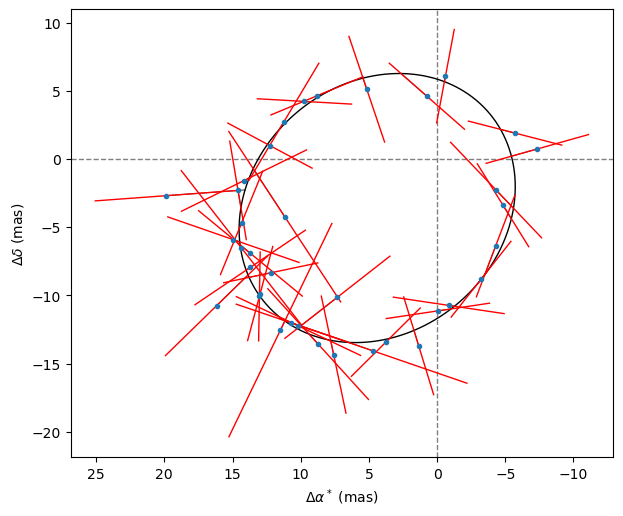

In [20]:
# Create figure for astrometric orbit plot
plt.figure(figsize=(7, 7))

# Plot connecting lines between measured and model positions
for k in range(len(a)):
    plt.plot(
        # X coordinates: measured to model position (right ascension)
        [
            astro_a_res[k],
            a[k],
        ],
        # Y coordinates: measured to model position (declination)
        [
            astro_d_res[k],
            d[k],
        ],
        "k",  # Black color
        lw=0.75,  # Line width
        alpha=0.75,  # Transparency
        zorder=0,  # Draw below other elements
    )

# Plot error bars for each measurement
for k in range(len(a)):
    plt.plot(
        [
            astro_a_res[k] - astro_a_err[k],
            astro_a_res[k] + astro_a_err[k],
        ],  # X error bars
        [
            astro_d_res[k] - astro_d_err[k],
            astro_d_res[k] + astro_d_err[k],
        ],  # Y error bars
        "r-",  # Red color
        lw=1,  # Line width
        zorder=2,  # Draw above connecting lines
    )

# Plot the model orbit
plt.plot(astro_a_mod, astro_d_mod, "k-", lw=1, rasterized=True, zorder=1)

# Plot the measured positions
plt.plot(astro_a_res, astro_d_res, ".", rasterized=True, zorder=3)

# Set axis labels
plt.xlabel("$\\Delta \\alpha^*$ (mas)")
plt.ylabel("$\\Delta \\delta$ (mas)")

# Invert x-axis (standard for astrometric plots)
plt.gca().invert_xaxis()

# Set equal aspect ratio
plt.gca().set_aspect("equal", adjustable="box")

# Get current axis limits
xlim = plt.xlim()
ylim = plt.ylim()

# Add zero reference lines
plt.plot(xlim, [0, 0], "--", c="gray", lw=1, zorder=-10)  # Horizontal line
plt.plot([0, 0], ylim, "--", c="gray", lw=1, zorder=-10)  # Vertical line

# Restore axis limits
plt.xlim(xlim)
plt.ylim(ylim)

### RV Orbit on the Timeseries

We will plot the RV orbit on the timeseries, showing the model predictions and residuals for each instrument.

Text(0, 0.5, '$\\Delta v$ (m/s)')

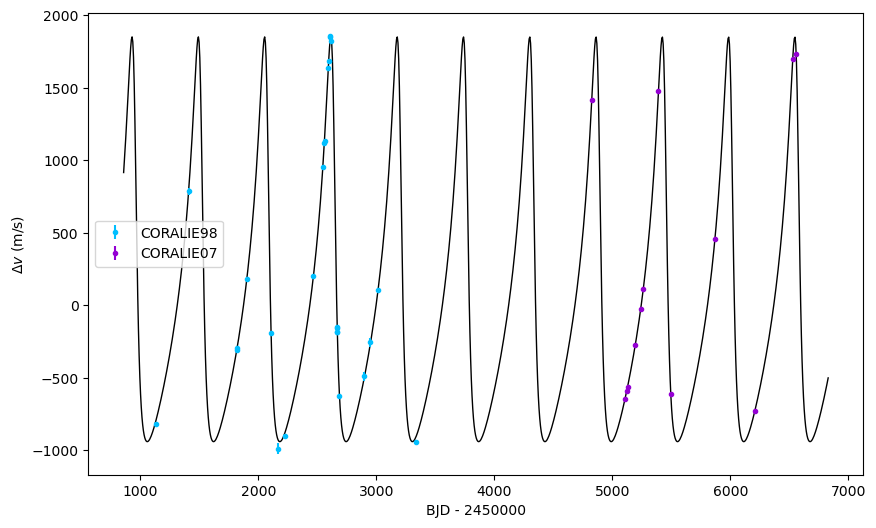

In [21]:
# Create smooth time array for plotting
rv_tsmooth = np.linspace(Tmin - dT / 20, Tmax + dT / 20, 1000)

# Calculate RV model predictions for smooth time array
rv_mod = kep.rv(rv_tsmooth)

# Get RV model predictions + residuals for actual data points
rv_kep_res = kep.rv(rv_model.t) + rv_res

# Create figure for RV time series plot
plt.figure(figsize=(10, 6))

# Plot the smooth RV model curve
plt.plot(rv_tsmooth, rv_mod, "k-", lw=1, rasterized=True)

# Plot data points for each instrument with error bars
for inst in instruments:
    # Select data points for current instrument
    kinst = rv_data.ins_name == inst

    # Plot points with error bars using instrument-specific colors
    plt.errorbar(
        rv_model.t[kinst],
        rv_kep_res[kinst],
        yerr=rv_res_err[kinst],
        fmt=".",
        c=default_inst_color.get(inst, None),
        rasterized=True,
        label=inst,
    )

# Add legend
plt.legend()

# Set axis labels
plt.xlabel(f"BJD - {epoch_bjd}")
plt.ylabel("$\\Delta v$ (m/s)")

### Phase-fold

We will create a phase-folded plot of the RV data, showing the model curve and residuals as a function of the mean anomaly.

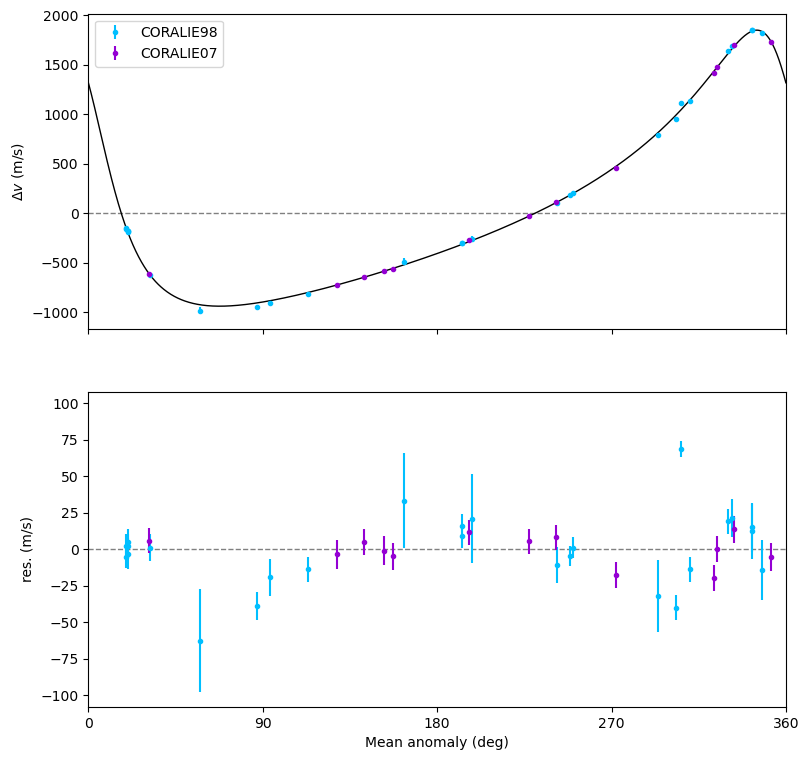

In [22]:
# Get the epoch of periapsis passage and period from the model
Tp = full_model.get_param("kep.0.Tp")
M_mod = np.linspace(0, 360, 1000)  # Create mean anomaly array for phase folding

# Calculate time array based on mean anomaly
rv_tsmooth = Tp + M_mod * P / 360

# Get RV model predictions and residuals
rv_mod = kep.rv(rv_tsmooth)  # Model RV curve
rv_kep_res = kep.rv(rv_model.t) + rv_res  # RV data with residuals

# Calculate mean anomaly for the observations
M_res = (360 * (rv_model.t - Tp) / P) % 360

# Create subplot with two panels
_, axs = plt.subplots(2, 1, sharex=True, figsize=(9, 9))

# Top panel: Phase-folded RV curve
ax = axs[0]
ax.plot([0, 360], [0, 0], "--", c="gray", lw=1)  # Zero line
ax.plot(M_mod, rv_mod, "k-", lw=1, rasterized=True)  # Model curve

# Plot data points by instrument
for inst in instruments:
    kinst = rv_data.ins_name == inst
    ax.errorbar(
        M_res[kinst],
        rv_kep_res[kinst],
        yerr=rv_res_err[kinst],
        fmt=".",
        c=default_inst_color.get(inst, None),
        label=inst,
        rasterized=True,
    )
ax.set_ylabel("$\\Delta v$ (m/s)")
ax.legend()

# Bottom panel: Residuals
ax = axs[1]
ax.plot([0, 360], [0, 0], "--", c="gray", lw=1)  # Zero line

# Plot residuals by instrument
for inst in instruments:
    kinst = rv_data.ins_name == inst
    ax.errorbar(
        M_res[kinst],
        rv_res[kinst],
        yerr=rv_res_err[kinst],
        fmt=".",
        c=default_inst_color.get(inst, None),
        rasterized=True,
    )

# Set axis labels and limits
ax.set_xlim(0, 360)
ylim = 1.1 * np.max(abs(rv_res) + rv_res_err)
ax.set_ylim(-ylim, ylim)
ax.set_xticks([0, 90, 180, 270, 360])
ax.set_xlabel("Mean anomaly (deg)")
ax.set_ylabel("res. (m/s)")

# Restore original model parameters
full_model.set_keplerian_param("0", param=parbak)